<a href="https://colab.research.google.com/github/hasibulhimu49/Multi_Class_Heart_Disease_Prediction_Using_Machine_Learning/blob/main/Multi_Class_Heart_Disease_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install necessary packages

In [ ]:
!pip install -U pycaret[full]
!pip install -U mlflow

#Connect Google Drive so we can load the dataset directly from there.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load the heart disease dataset from Google Drive using pandas.

In [ ]:
import pandas as pd
import numpy as np
dataset_path = '/content/drive/MyDrive/DataSET/heart_disease_uci.csv'
df = pd.read_csv(dataset_path)


 # Preprocessing

In [ ]:
# Drop unnecessary columns
df.drop(columns=['id', 'dataset','exang','fbs'], inplace=True, errors='ignore')
# Rename target column
df.rename(columns={'num': 'target'}, inplace=True)
# 'sex' mapping remains as it's not deleted
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
# One-hot encode categorical features
df = pd.get_dummies(df, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)
# Convert boolean to integers (if any)
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

# Preparing Data for SMOTE Oversampling

In [ ]:
# Exclude the 'target' column from imputation if it's already clean
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'target' in numerical_cols:
    numerical_cols.remove('target')

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
print("\nNaN counts after imputation:")
print(df.isnull().sum())
print("\n" + "="*40 + "\n")


import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE



NaN counts after imputation:
age                         0
sex                         0
trestbps                    0
chol                        0
thalch                      0
oldpeak                     0
ca                          0
target                      0
cp_atypical angina          0
cp_non-anginal              0
cp_typical angina           0
restecg_normal              0
restecg_st-t abnormality    0
slope_flat                  0
slope_upsloping             0
thal_normal                 0
thal_reversable defect      0
dtype: int64




#VISUALIZATION: Before SMOTE  All Class Look like

--- Class Distribution BEFORE SMOTE ---


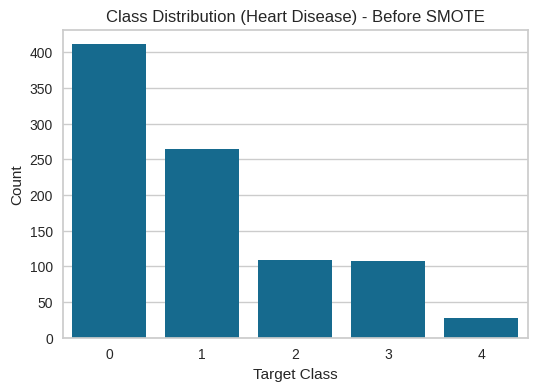

Value counts before SMOTE:
 target
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


In [ ]:
print("--- Class Distribution BEFORE SMOTE ---")
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Class Distribution (Heart Disease) - Before SMOTE')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.show()
print("Value counts before SMOTE:\n", df['target'].value_counts())
X = df.drop('target', axis=1)
y = df['target']


# Apply SMOTE for Balancing imbalanced classes

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [ ]:
# Create a DataFrame from the resampled data for visualization
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['target'] = y_res

#VISUALIZATION: AFTER SMOTE  All Class Look like


--- Class Distribution AFTER SMOTE (for visualization) ---


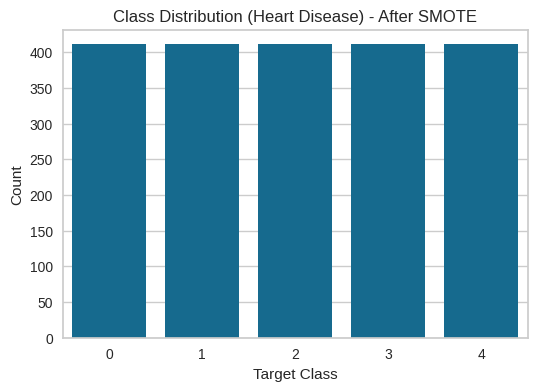

Value counts after SMOTE:
 target
0    411
2    411
1    411
3    411
4    411
Name: count, dtype: int64


In [ ]:
print("\n--- Class Distribution AFTER SMOTE (for visualization) ---")
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_resampled)
plt.title('Class Distribution (Heart Disease) - After SMOTE')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.show()
print("Value counts after SMOTE:\n", df_resampled['target'].value_counts())


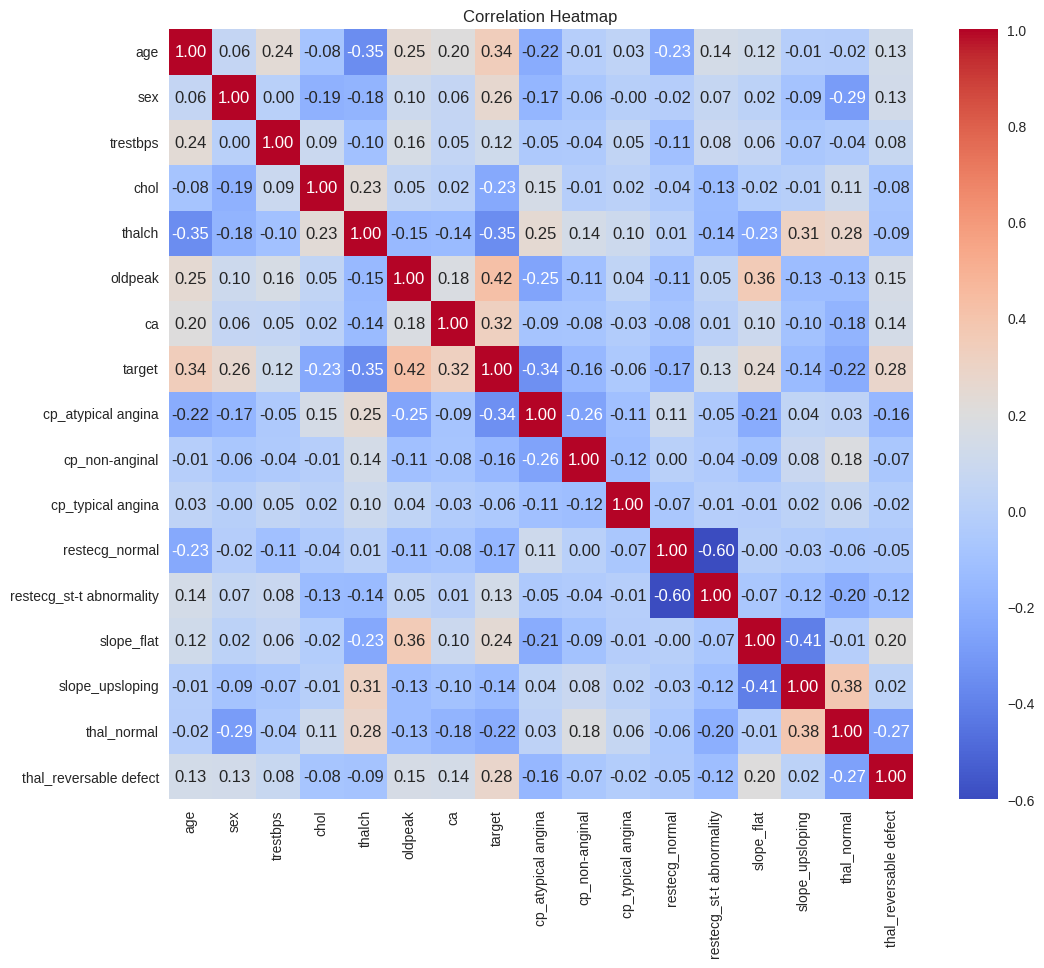

In [ ]:
# Correlation heatmap (using original df, as SMOTE is for training balance)
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Set up the PyCaret environment to define our data, target, and experiment settings.

In [ ]:
# STEP 5: Setup PyCaret
from pycaret.classification import *


In [ ]:

env = setup(
    data=df,
    target='target',
    session_id=42,
    normalize=True,
    remove_multicollinearity=True,
    log_experiment=False,
    experiment_name='heart_disease',
    fix_imbalance=True,
    fix_imbalance_method='SMOTE'
)

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(920, 17)"
4,Transformed data shape,"(1716, 17)"
5,Transformed train set shape,"(1440, 17)"
6,Transformed test set shape,"(276, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


# Model Training and Tuning

Compare different models to find the best one and then fine-tune it.

In [ ]:
best_model = compare_models()
tuned_model = tune_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.5747,0.8041,0.5747,0.5662,0.5642,0.3713,0.3750,0.6390
catboost,CatBoost Classifier,0.5699,0.8071,0.5699,0.5696,0.5644,0.3709,0.3737,19.2320
rf,Random Forest Classifier,0.5654,0.7996,0.5654,0.5573,0.5553,0.3579,0.3611,0.3790
lightgbm,Light Gradient Boosting Machine,0.5622,0.8020,0.5622,0.5504,0.5505,0.3522,0.3552,6.2950
et,Extra Trees Classifier,0.5621,0.7978,0.5621,0.5549,0.5531,0.3568,0.3596,0.2750
gbc,Gradient Boosting Classifier,0.5543,0.0000,0.5543,0.5546,0.5495,0.3479,0.3502,1.9450
lda,Linear Discriminant Analysis,0.5279,0.0000,0.5279,0.5851,0.5476,0.3441,0.3493,0.0840
ridge,Ridge Classifier,0.5217,0.0000,0.5217,0.5660,0.5338,0.3284,0.3341,0.0860
lr,Logistic Regression,0.5185,0.0000,0.5185,0.5606,0.5333,0.3258,0.3295,0.8560
qda,Quadratic Discriminant Analysis,0.5169,0.0000,0.5169,0.5725,0.5350,0.3269,0.3333,0.0490


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7077,0.8915,0.7077,0.6953,0.6972,0.5709,0.5737
1,0.5231,0.7218,0.5231,0.4903,0.4984,0.2780,0.2833
2,0.6462,0.8522,0.6462,0.6560,0.6365,0.4831,0.4890
3,0.5692,0.8148,0.5692,0.5865,0.5748,0.3880,0.3898
4,0.6094,0.8392,0.6094,0.6264,0.6168,0.4392,0.4398
5,0.5156,0.7569,0.5156,0.5436,0.5222,0.2942,0.2980
6,0.5938,0.8143,0.5938,0.5582,0.5716,0.3853,0.3884
7,0.6719,0.8081,0.6719,0.6349,0.6514,0.5053,0.5078
8,0.5156,0.7901,0.5156,0.4785,0.4947,0.2858,0.2880


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


# Evaluate Model

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

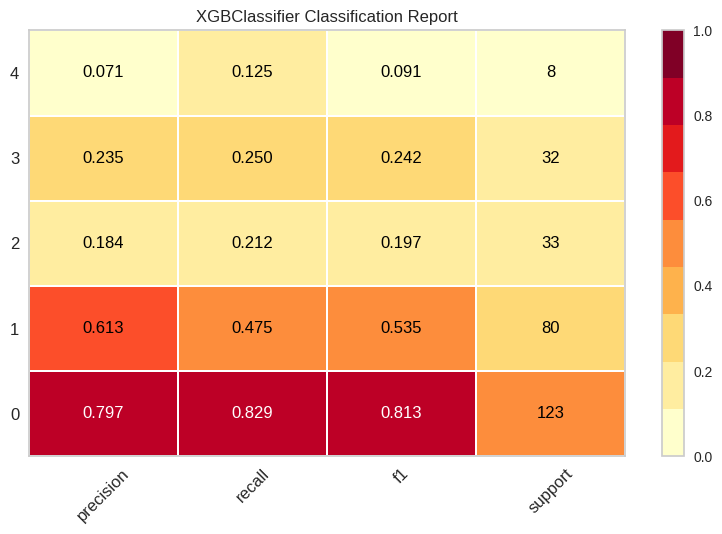

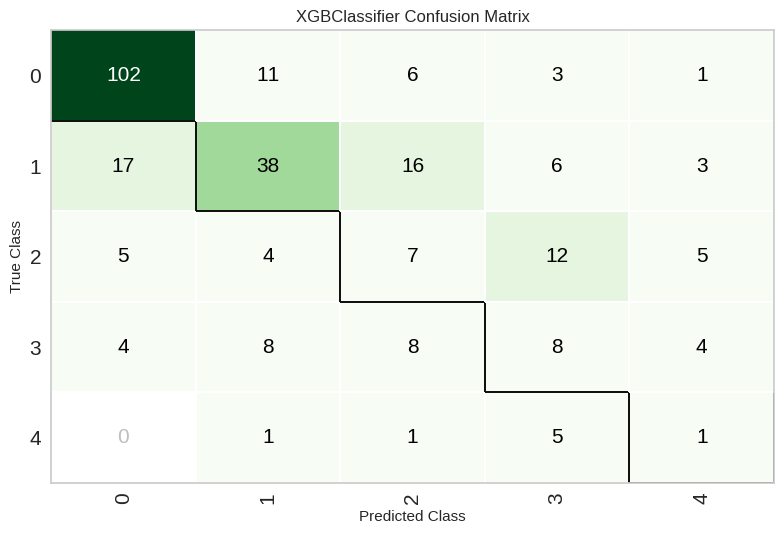

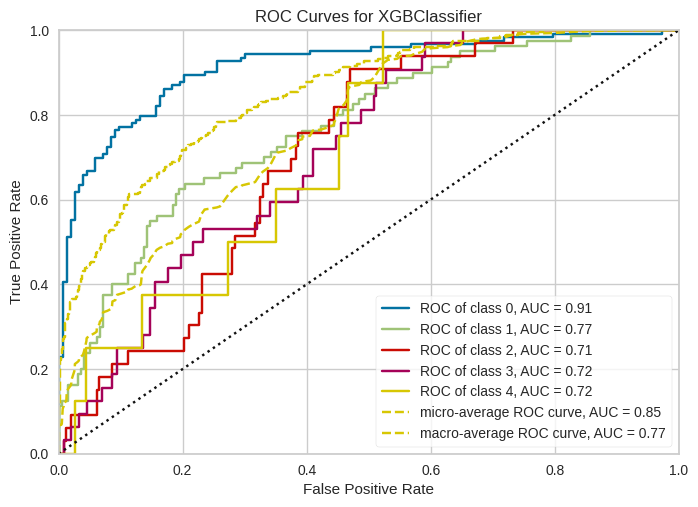

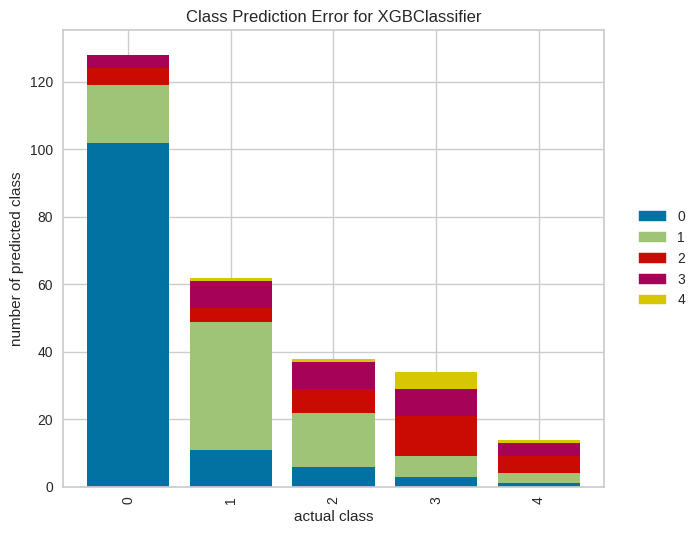

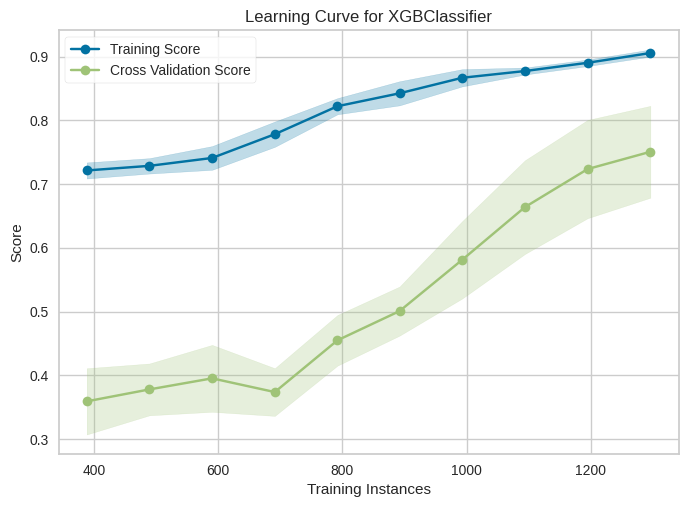

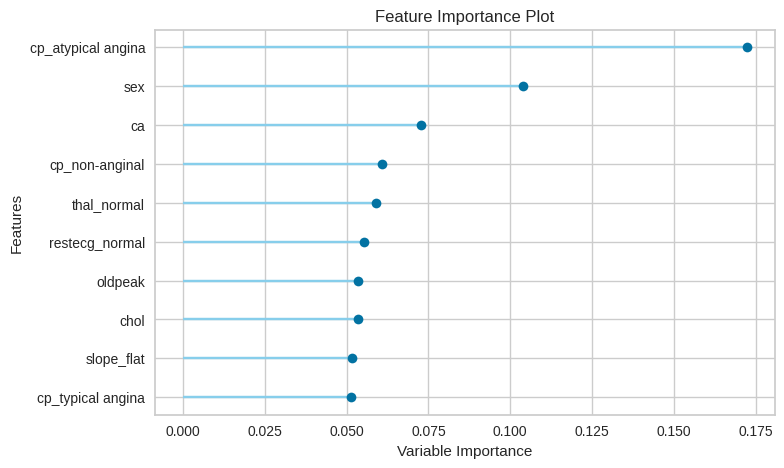

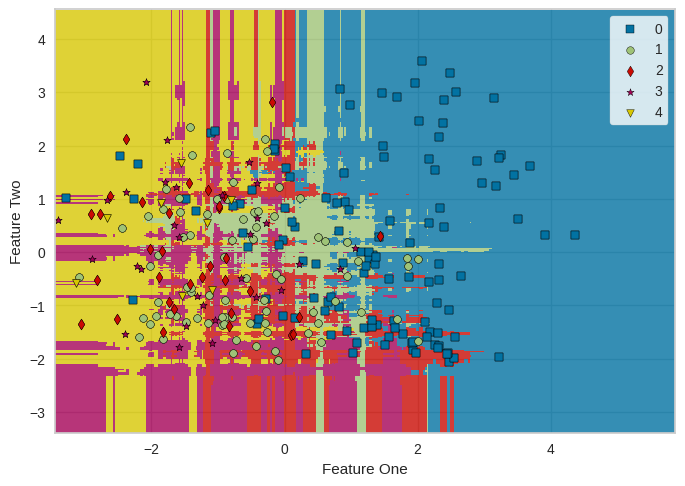

In [ ]:
evaluate_model(tuned_model)

# Overall performance summary
plot_model(tuned_model, plot='class_report')

# Detailed performance visualizations
plot_model(tuned_model, plot='confusion_matrix')
plot_model(tuned_model, plot='auc')
plot_model(tuned_model, plot='error')

# Learning insights
plot_model(tuned_model, plot='learning')

# Model explainability
plot_model(tuned_model, plot='feature')

# Decision surface (if applicable)
plot_model(tuned_model, plot='boundary')

# Test CatBoost, Linear Discriminant Analysis model separately

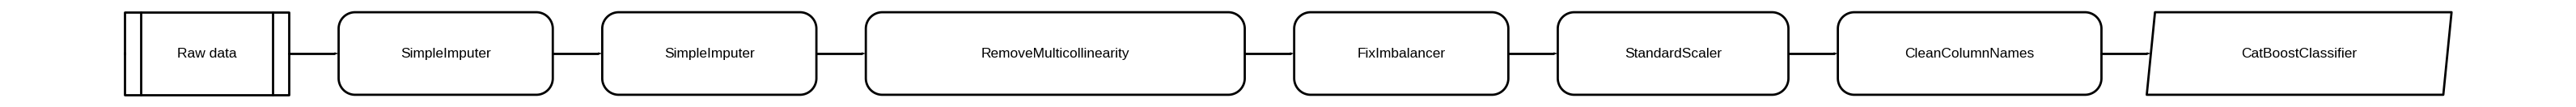

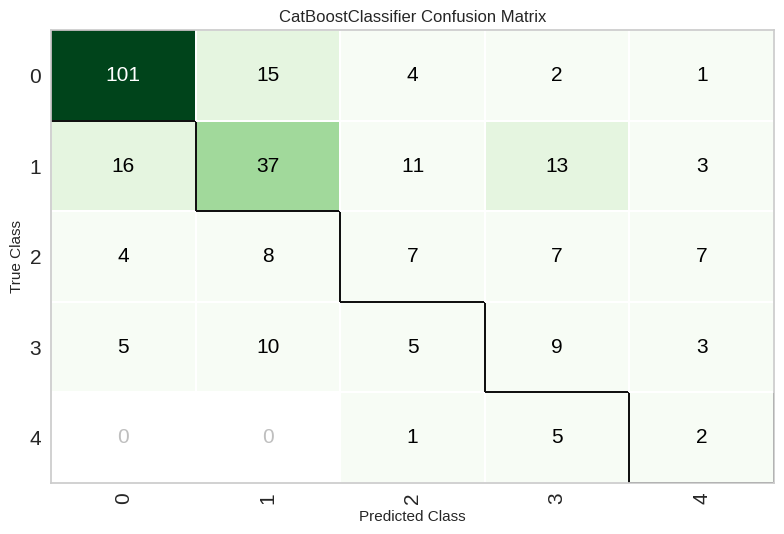

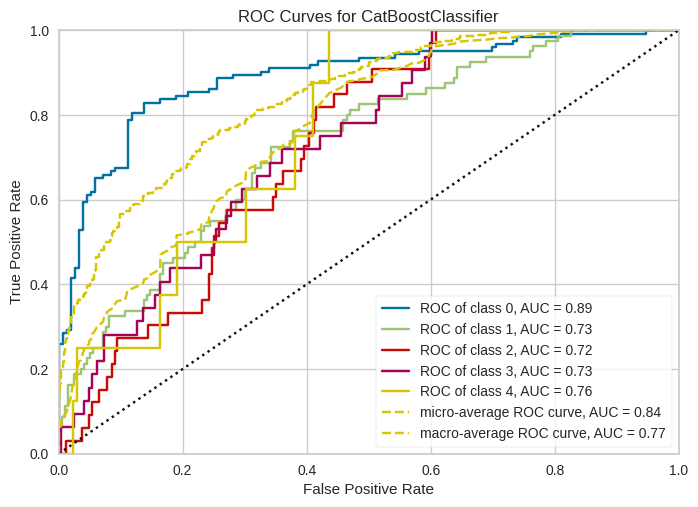

In [ ]:
catboost_model = create_model('catboost')
tuned_catboost = tune_model(catboost_model)
evaluate_model(tuned_catboost)
plot_model(tuned_catboost, plot='confusion_matrix')
plot_model(tuned_catboost, plot='auc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5538,0.0000,0.5538,0.6820,0.6026,0.3978,0.4090
1,0.4923,0.0000,0.4923,0.5482,0.5170,0.2963,0.2987
2,0.5846,0.0000,0.5846,0.6040,0.5866,0.4146,0.4174
3,0.5231,0.0000,0.5231,0.6057,0.5524,0.3481,0.3545
4,0.5000,0.0000,0.5000,0.5694,0.5249,0.3162,0.3207
5,0.5312,0.0000,0.5312,0.5709,0.5392,0.3312,0.3380
6,0.5469,0.0000,0.5469,0.5668,0.5536,0.3553,0.3568
7,0.5312,0.0000,0.5312,0.5738,0.5511,0.3379,0.3390
8,0.5156,0.0000,0.5156,0.5505,0.5274,0.3254,0.3281


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5538,0.0000,0.5538,0.6820,0.6026,0.3978,0.4090
1,0.4923,0.0000,0.4923,0.5482,0.5170,0.2963,0.2987
2,0.5846,0.0000,0.5846,0.6040,0.5866,0.4146,0.4174
3,0.5231,0.0000,0.5231,0.6057,0.5524,0.3481,0.3545
4,0.5000,0.0000,0.5000,0.5694,0.5249,0.3162,0.3207
5,0.5312,0.0000,0.5312,0.5709,0.5392,0.3312,0.3380
6,0.5469,0.0000,0.5469,0.5668,0.5536,0.3553,0.3568
7,0.5312,0.0000,0.5312,0.5738,0.5511,0.3379,0.3390
8,0.5156,0.0000,0.5156,0.5505,0.5274,0.3254,0.3281


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

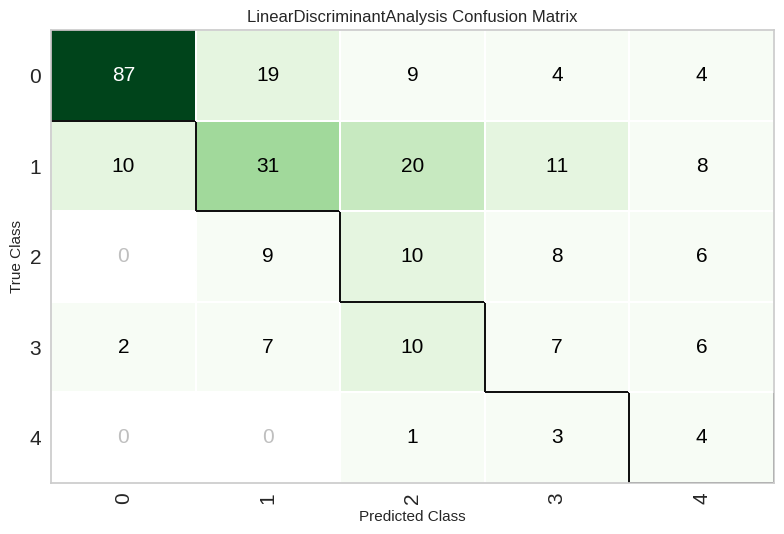

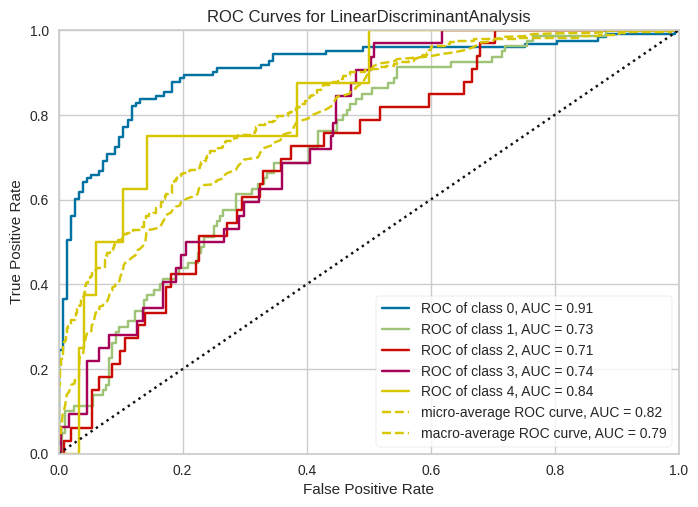

In [ ]:
Linear_Discriminant_Analysis_model = create_model('lda')
Linear_Discriminant_Analysis = tune_model(Linear_Discriminant_Analysis_model)
evaluate_model(Linear_Discriminant_Analysis)
plot_model(Linear_Discriminant_Analysis, plot='confusion_matrix')
plot_model(Linear_Discriminant_Analysis, plot='auc')


# Make predictions
We use the tuned model to make predictions on the dataset.

In [ ]:
predictions = predict_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.5652,0.8196,0.5652,0.5842,0.5717,0.3753,0.3768


#Show predictions
Display the predicted labels and prediction scores for the first 10 rows.

In [ ]:
# STEP 9: Show predictions
print(predictions[['target', 'prediction_label']].head(10))
print(predictions[['prediction_score']].head(10))

     target  prediction_label
525       1                 1
778       0                 0
680       3                 3
504       1                 1
482       0                 0
478       0                 0
101       0                 0
365       0                 0
471       0                 0
842       1                 1
     prediction_score
525            0.7034
778            0.4081
680            0.4468
504            0.5004
482            0.7410
478            0.6525
101            0.8086
365            0.8859
471            0.7439
842            0.6626


 # Finalize and Save the Model (For Deployment)





In [ ]:
final_model = finalize_model(tuned_model)
print(f"\nFinal model ready for deployment: {final_model}")

save_model(final_model, '/content/drive/MyDrive/DataSET/pycaret_heart_disease_multi_class_model')
print("\nModel saved as 'pycaret_heart_disease_multi_class_model.pkl' in your Google Drive.")


Final model ready for deployment: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'sex', 'trestbps', 'chol',
                                             'thalch', 'oldpeak', 'ca',
                                             'cp_atypical angina',
                                             'cp_non-anginal',
                                             'cp_typical angina',
                                             'restecg_normal',
                                             'restecg_st-t abnormality',
                                             'slope_flat', 'slope_upsloping',
                                             'thal_normal',
                                             'thal_reversable defect'],
                                    transformer=SimpleIm...
                               importance_type=None,
                               i